In [1]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

def extract_and_save_2d_slices(source_db_path, target_db_path, source_table_name='noises', target_table_name='slices_ns'):
    # Connect to the source database
    source_conn = sqlite3.connect(source_db_path)
    source_cursor = source_conn.cursor()
    
    # Connect to the target database (this will create it if it doesn't exist)
    target_conn = sqlite3.connect(target_db_path)
    target_cursor = target_conn.cursor()
    
    # Create the target table if it doesn't exist
    target_cursor.execute(f'''CREATE TABLE IF NOT EXISTS {target_table_name} (
                              id INTEGER PRIMARY KEY,
                              data BLOB
                              )''')
    
    # Query to select all arrays from the source database
    source_cursor.execute(f'SELECT id, data FROM {source_table_name}')
    
    for row in source_cursor.fetchall():
        array_id, data = row
        # Deserialize the 3D array data
        array = np.frombuffer(data, dtype=np.float32).reshape((64, 64, 86))
        
        # Extract the first 2D slice
        slice_2d = array[:, :, 0]  # Assuming you want the first slice along the third dimension
        
        # Serialize the 2D slice
        slice_data = slice_2d.tobytes()
        
        # Insert the 2D slice into the target database
        target_cursor.execute(f'INSERT INTO {target_table_name} (id, data) VALUES (?, ?)', (array_id, slice_data))
    
    # Commit changes and close connections
    target_conn.commit()
    source_conn.close()
    target_conn.close()



def count_samples_in_database(db_path, table_name='slices_lc'):
    # Connect to the database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Execute the count query
    cursor.execute(f'SELECT COUNT(*) FROM {table_name}')
    count = cursor.fetchone()[0]
    
    conn.close()
    
    print(f"Number of samples in the database '{db_path}': {count}")



def print_sample_shape(db_path, sample_id, table_name='slices_lc'):
    # Connect to the database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Fetch a single sample by ID
    cursor.execute(f'SELECT data FROM {table_name} WHERE id=?', (sample_id,))
    data = cursor.fetchone()[0]
    
    # Deserialize the data
    array = np.frombuffer(data, dtype=np.float32)
    
    # Assuming you know the original shape, or if the 2D slice is square (e.g., 64x64)
    # If not, you would need to adjust the reshape method accordingly
    shape = (64, 64)  # Adjust this based on your actual data shape
    array = array.reshape(shape)
    
    print(f"Shape of sample {sample_id}: {array.shape}")
    
    conn.close()
    return array




In [3]:
source_db_path1 = 'databases/lightcones.db'
target_db_path1 = 'databases/lightcones_2D.db'
extract_and_save_2d_slices(source_db_path1, target_db_path1)



In [5]:
source_db_path2 = 'databases/noises.db'
target_db_path2 = 'databases/noises_2D.db'
extract_and_save_2d_slices(source_db_path2, target_db_path2)

Number of samples in the database 'databases/lightcones_2D.db': 10001
Shape of sample 1: (64, 64)


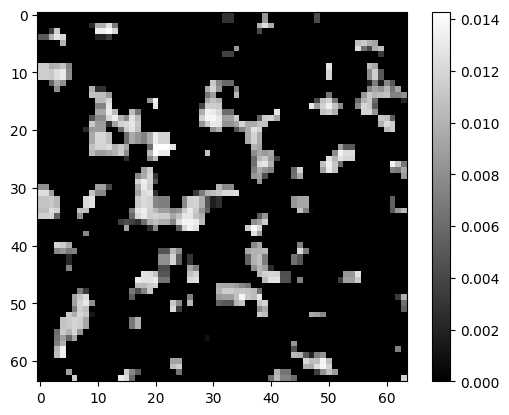

In [2]:
db_path = 'databases/lightcones_2D.db'  # Adjust this to your target database path
count_samples_in_database(db_path)
sample_id = 1  # Example sample ID, adjust as needed
array = print_sample_shape(db_path, sample_id)
plt.imshow(array, cmap='gray')  # Use an appropriate colormap for your data
plt.colorbar()
plt.show()